In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import keras

print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [3]:
IMAGE_SIZE = 96
IMAGE_CHANNEL = 3
BATCH_SIZE = 32
SAMPLE_SIZE = 20_000

In [4]:
from typing import Literal

def get_running_environment() -> Literal['local', 'colab', 'kaggle', 'marimo', 'jupyter']:
    """
    Returns the current running environment.
    """
    if 'COLAB_GPU' in os.environ:
        return 'colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'kaggle'
    elif 'MARIMO' in os.environ:
        return 'marimo'
    elif 'JUPYTERHUB_USER' in os.environ:
        return 'jupyter'
    else:
        return 'local'
current_env = get_running_environment()

def get_data_path(running_env: str) -> str:
    """
    Returns the path to the data directory based on the running environment.
    """
    if running_env == 'colab':
        return '/content/data'
    elif running_env == 'kaggle':
        return '/kaggle/input/histopathologic-cancer-detection'
    elif running_env == 'marimo':
        return '/data'
    else:
        return './data/histopathologic-cancer-detection'
        # return './data'
    
def set_random_seed(seed: int = 42):
    """
    Sets the random seed for reproducibility.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seed set to {seed}")

data_dir = get_data_path(current_env)
print(f"Data path: {data_dir} (for {current_env} environment)")

RANDOM_SEED = 42

set_random_seed(RANDOM_SEED)

Data path: ./data/histopathologic-cancer-detection (for local environment)
Random seed set to 42


## Dataset and Sampling

First I read the `train_labels.csv` file to get the labels for the training data. Then I create a `tf.data.Dataset` object from the training data directory, which contains images and their corresponding labels. The dataset is shuffled and batched for training. Considering the dataset is big, I use the `SAMPLE_SIZE` variable to limit the number of samples used for training and validation. This is useful for quick iterations and testing. 

To sample the dataset, first I calculate the ratios of the classes in the dataset. Then I sample the dataset based on these ratios to create a balanced training and validation set with the same class distribution. 

In [5]:
df_full = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))


if SAMPLE_SIZE > 0:
    print(f"SAMPLE_SIZE is set to {SAMPLE_SIZE}. Sampling the dataset...")

    total_0 = df_full[df_full['label'] == 0].value_counts('label').values[0]
    total_1 = df_full[df_full['label'] == 1].value_counts('label').values[0]

    ratio = total_1 / total_0
    print(f"Total samples with label 0: {total_0}, label 1: {total_1}, ratio: {ratio}")

    target_1 = int(SAMPLE_SIZE * ratio / (1 + ratio))
    target_0 = SAMPLE_SIZE - target_1
    print(f"Target samples with label 0: {target_0}, label 1: {target_1}")

    df_0 = df_full[df_full['label'] == 0].sample(target_0, random_state=RANDOM_SEED)
    df_1 = df_full[df_full['label'] == 1].sample(target_1, random_state=RANDOM_SEED)

    df = pd.concat([df_0, df_1]).reset_index(drop=True)
else:
    print(f"SAMPLE_SIZE has not been set. Using full dataset with {len(df_full)} samples.")
    df = df_full.copy()
df

SAMPLE_SIZE is set to 20000. Sampling the dataset...
Total samples with label 0: 130908, label 1: 89117, ratio: 0.680760534115562
Target samples with label 0: 11900, label 1: 8100


,id,label
0,941ffe73059292e0effd4e81ca9363c117afc2f4,0
1,43b6acadb31161c9281460efa3fad0b992a92837,0
2,64cfb56ddf41e2a871ac5164d61e50b238b9ed1b,0
3,9464cf403653088420cdb78acacd8cf7fa2255e4,0
4,346bc5b2d383d70dfccb8fe9102c7f55687f5f52,0
...,...,...
19995,15e54396066234dde4b2bf8e7cea3dda24784db2,1
19996,722d38057ad1f69d38ed363a0084ce8880ff426a,1
19997,62f639419c18af00bb19aabe7d7c7bf44a5e4b9f,1
19998,495cd802b974c5ff880a7fbf236eafe02c11db4d,1


In [6]:
df.value_counts('label')

label
0    11900
1     8100
Name: count, dtype: int64

## Preprocessing

Keras provides a convenient way to preprocess images using the `tf.keras.preprocessing.image_dataset_from_directory` function. It automatically labels the images based on the directory structure and applies basic preprocessing like resizing and rescaling.

The directory structure is expected to be like this:

```data/
    train/
        0/  # Class 0 images
            image_1.jpg
            image_2.jpg
            ...
        1/ # Class 1 images
            image_1.jpg
            image_2.jpg
            ...
```

It also doesn't support `.tif` files, so I convert the images to `.jpg` format before using them. 

`DataPreprocessor` class is used to handle the preprocessing of images. It has a `run` method that takes the directory path and does the following:

1. Reads the labels from the `train_labels.csv` file. It is also possible to pass the dataset as a parameter, in this case, it considers the dataset is already loaded.
2. Go through each image (`.tif`) in the directory and convert it to `.jpg`.
3. For training data, it reads the labels from the dataset and move the images to the corresponding class directories.
4. For validation data, we don't have labels, so it just moves the images to a separate directory.
5. Returns the path to the preprocessed training and validation directories.

In [7]:
from prepare_dataset import DataPreprocessor
data_processor = DataPreprocessor(data_dir=data_dir, dataset=df, output_dir='./data/sample')

In [8]:
train_processed_dir = data_processor.run('train', forced=True)
print(f"Processed train directory: {train_processed_dir}")

test_processed_dir = data_processor.run('test', forced=True)
print(f"Processed test directory: {test_processed_dir}")

processed directory exists
Removing the current directory
creating directories for processed images


Converting images: 100%|██████████| 20000/20000 [00:02<00:00, 9842.16it/s] 


Processed train directory: ./data/sample/train_processed
processed directory exists
Removing the current directory
creating directories for processed images


Converting images: 100%|██████████| 57458/57458 [00:05<00:00, 11271.74it/s]


Processed test directory: ./data/sample/test_processed


In [9]:
VALIDATION_SPLIT = 0.2

train_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Binary labels (0 or 1)
)
val_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)
test_ds = image_dataset_from_directory(
    test_processed_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=None,  # No labels for test
    shuffle=False  # Preserve order for submission
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


2025-07-29 06:40:16.546651: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-07-29 06:40:16.546681: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-07-29 06:40:16.546690: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1753764016.546701 2838367 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753764016.546723 2838367 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Found 57458 files.


2025-07-29 06:40:19.261111: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


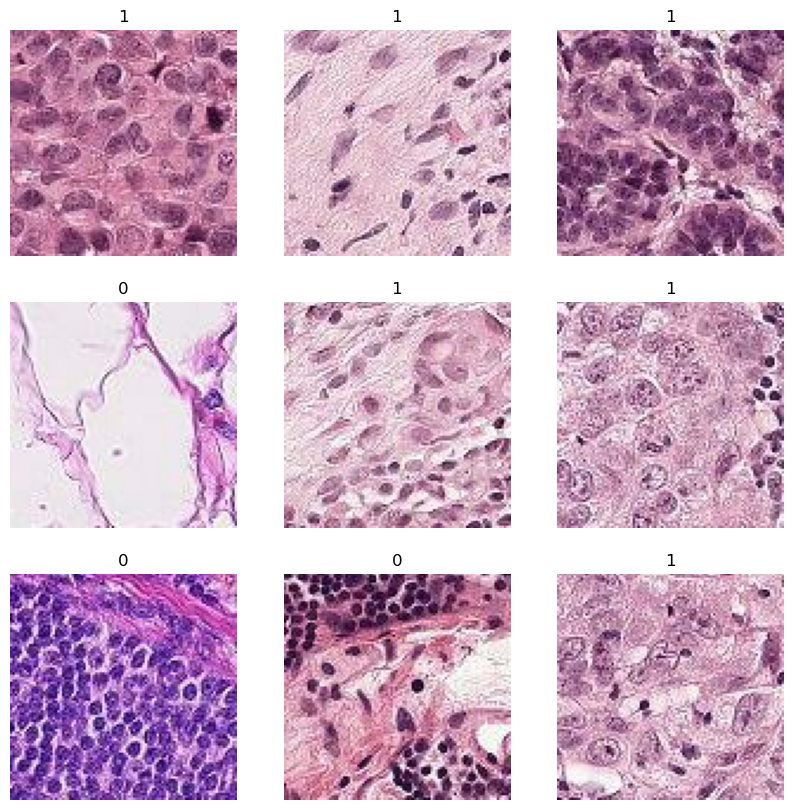

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

Now that we have the preprocessed data, we can apply data augmentation to increase the diversity of our training dataset. I used four classes of data augmentation techniques: rotation, horizontal flip, vertical flip, random contrast, and random brightness. These techniques help the model generalize better by introducing variations in the training data.

Note that, I avoided using techniques like zoom, shear, or cropping as they might not be suitable for histopathological images where the entire image is important for classification.

In [11]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


2025-07-29 06:40:19.938294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


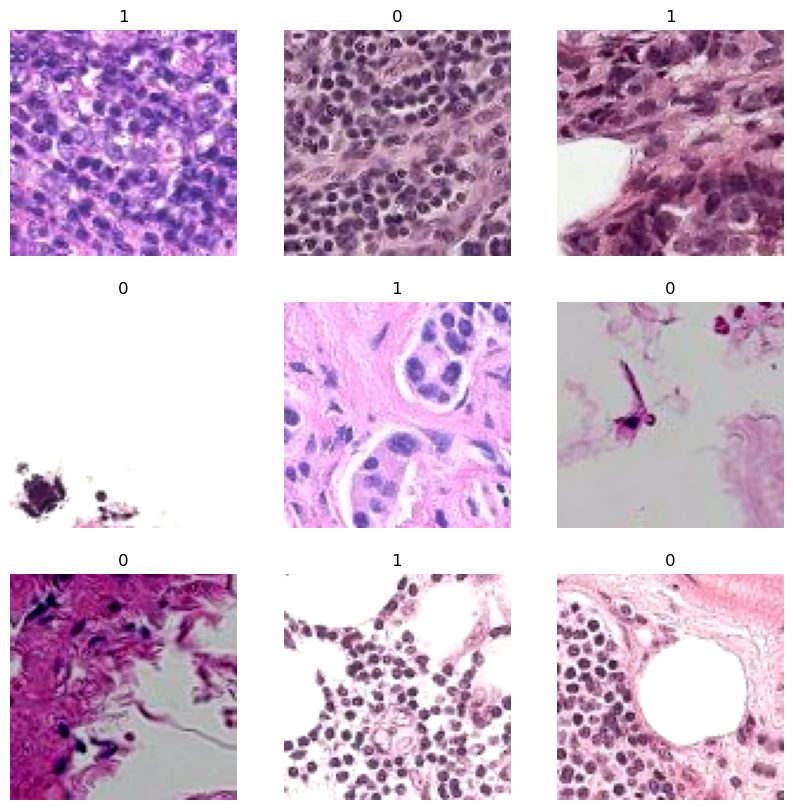

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images[i:i+1])
        plt.imshow(np.array(augmented_image[0]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
# apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Building the Model

Let's start with building the models. For all the models, I used the `adam` optimizer with a learning rate of `0.001`, and the `binary_crossentropy` loss function since this is a binary classification problem. Additionally, I used the `AUC` metric to evaluate the model's performance, as it is the requirement for the Kaggle competition.

I used `get_class_weights` function to get the class weights based on the class distribution in the training dataset. This is useful to handle the slight class imbalance in the dataset. The class weights are passed to the `fit` method of the model to balance the loss function during training.

In [14]:
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(dataset: pd.DataFrame) -> dict:
    """
    Computes class weights for the dataset.
    """
    labels = dataset['label'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    return class_weight_dict


In [15]:
from datetime import datetime


def predict_and_save_submission(
    keras_model: keras.Model, model_name: str, test_dataset: tf.data.Dataset, output_dir: str
) -> tuple:
    # Predict
    test_ids = [f[:-4] for f in os.listdir(test_processed_dir) if f.endswith(".jpg")]
    predictions = keras_model.predict(test_dataset).flatten()
    submission = pd.DataFrame(
        {"id": test_ids, "label": (predictions > 0.5).astype(int)}
    )

    # Save submission with date and time in the filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    submission_filename = f"submission_{model_name}_{timestamp}.csv"
    print(f"Saving submission to {submission_filename}")

    submission_path = os.path.join(output_dir, submission_filename)

    submission.to_csv(submission_path, index=False)
    return (predictions, submission_path)

In [16]:
def plot_training_history(history):
    """
    Generates plots for training & validation metrics (Accuracy, Loss, and AUC if available).

    Args:
      history: A Keras History object.
    """
    # --- Data Extraction ---
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Check if AUC data is available
    has_auc = 'AUC' in history.history and 'val_AUC' in history.history
    if has_auc:
        auc = history.history['AUC']
        val_auc = history.history['val_AUC']

    # --- Plotting ---
    num_plots = 3 if has_auc else 2
    plt.figure(figsize=(8 * num_plots, 5))
    plt.suptitle('Model Training History', fontsize=16)

    # 📈 Plot 1: Accuracy
    plt.subplot(1, num_plots, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # 📉 Plot 2: Loss
    plt.subplot(1, num_plots, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # 🎯 Plot 3: AUC (if available)
    if has_auc:
        plt.subplot(1, num_plots, 3)
        plt.plot(epochs, auc, 'bo-', label='Training AUC')
        plt.plot(epochs, val_auc, 'ro--', label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [17]:
def get_lr_schedule(lr=1e-2, decay_steps=10000, decay_rate=0.9):
    """ 
    Returns a learning rate schedule for training.

    """
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate)
    return lr_schedule

In [18]:
EPOCHS = 20
METRICS = ['accuracy', 'AUC']
LOSS = 'binary_crossentropy'

### Simple CNN Model

First I use a very simple CNN model with a few convolutional layers just to get started and test the end to end pipeline. The model consists of:
1. **Convolutional Layers**: These layers apply convolution operations to the input images, extracting features from them.
2. **Pooling Layers**: These layers downsample the feature maps, reducing their spatial dimensions and retaining the most important features.
3. **Flatten Layer**: This layer flattens the output of the convolutional layers into a 1D vector, which is then fed into the fully connected layers.
4. **Dense Layers**: These layers are fully connected layers that learn to classify the features extracted by the convolutional layers.

In [19]:
def build_simple_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)) -> keras.Model:
    """
    Builds a simple CNN model.
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [20]:
simple_cnn = build_simple_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL))

simple_cnn.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss=LOSS,
    metrics=METRICS
)
print(simple_cnn.summary())

# fit 
simple_cnn_history = simple_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=get_class_weights(df),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("checkpoints/simple_cnn/save_at_{epoch}.keras"),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
    ]
)

# predict on the test dataset
predictions, _ = predict_and_save_submission(simple_cnn,  "simple_cnn", test_ds, output_dir='./submissions')
predictions = (predictions > 0.5).astype(int)  # Convert probabilities
predictions = predictions.flatten()  # Flatten to 1D array

# precent of predictions by label
percent_0 = np.mean(predictions == 0) * 100
percent_1 = np.mean(predictions == 1) * 100
print(f"Predictions: {percent_0:.2f}% label 0, {percent_1:.2f}% label 1")
print(f"Total predictions: {len(predictions)}, label 0: {np.sum(predictions == 0)}, label 1: {np.sum(predictions == 1)}")

predict_and_save_submission(simple_cnn, "simple_cnn", test_ds, output_dir='./submissions')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        70,689 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,585 (279.63 KB)

 Trainable params: 71,585 (279.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


2025-07-29 06:40:20.382257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 0.6420 - accuracy: 0.6276 - loss: 8.1356 - val_AUC: 0.6752 - val_accuracy: 0.6622 - val_loss: 3.2511
Epoch 2/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.6892 - accuracy: 0.6364 - loss: 2.7960

/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 0.6866 - accuracy: 0.6514 - loss: 3.0898 - val_AUC: 0.7475 - val_accuracy: 0.7090 - val_loss: 2.3248
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 0.7040 - accuracy: 0.6632 - loss: 2.2096 - val_AUC: 0.7116 - val_accuracy: 0.6923 - val_loss: 2.2667
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 0.6955 - accuracy: 0.6531 - loss: 1.6879 - val_AUC: 0.7277 - val_accuracy: 0.6505 - val_loss: 1.8472
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 0.7033 - accuracy: 0.6592 - loss: 1.3016 - val_AUC: 0.7228 - val_accuracy: 0.6880 - val_loss: 1.3572
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 0.7099 - accuracy: 0.6661 - loss: 1.0208 - val_AUC: 0.7323 - val_accuracy: 0.6990 - val_loss: 1.3099
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 0.7156 - accuracy: 0.6705 - loss: 0.8832 - val_AUC: 0.7176 - val_accuracy: 0.6877 - val_loss: 1.1716
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18

(array([1.1772121e-02, 5.4354198e-02, 2.6453375e-03, ..., 2.9596537e-01,
        3.2065701e-02, 2.9685746e-06], shape=(57458,), dtype=float32),
 './submissions/submission_simple_cnn_20250729_064337.csv')

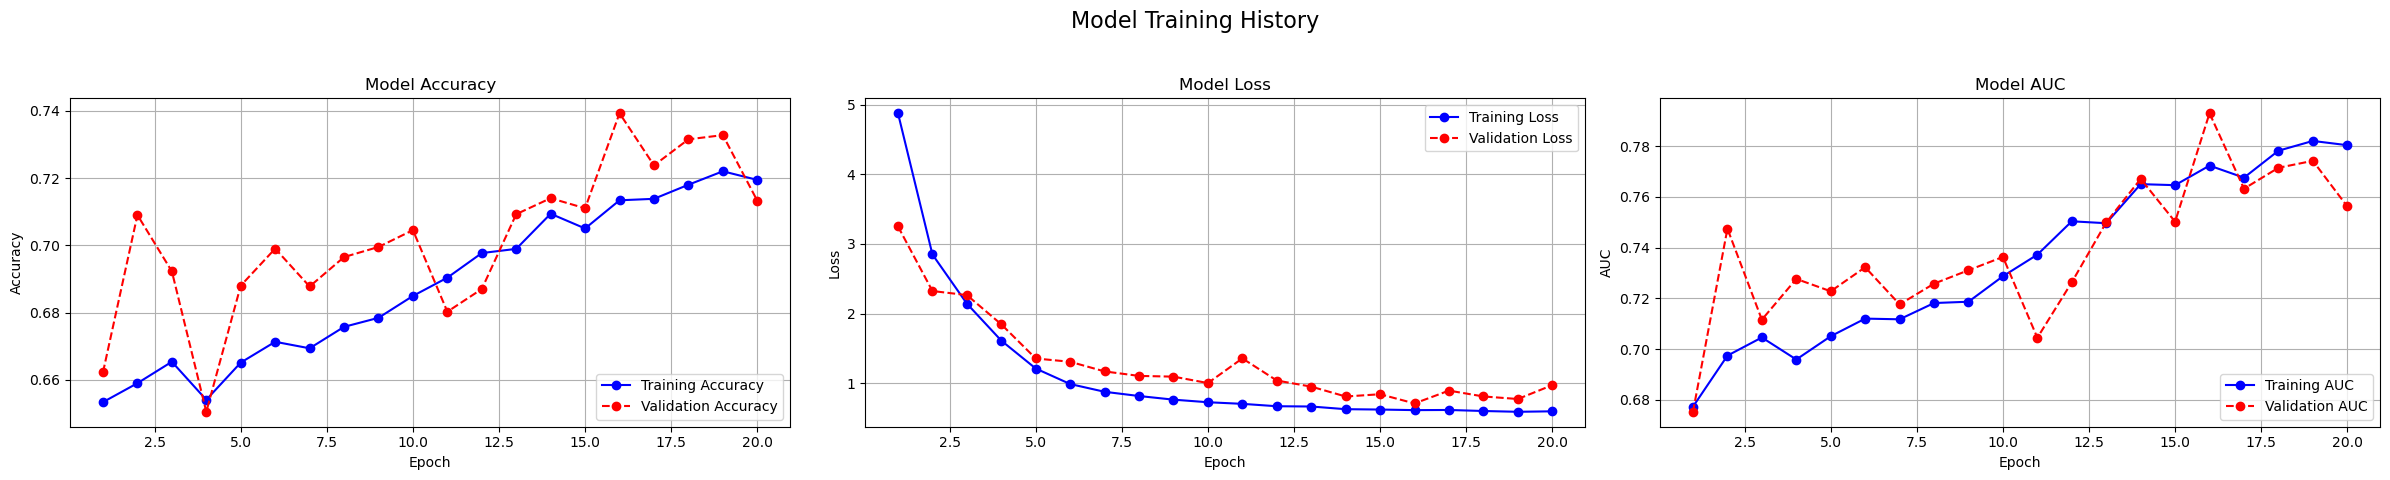

In [21]:
plot_training_history(simple_cnn_history)

## ResNet

Next, I use a pre-trained ResNet model for transfer learning. Here I also used `ExponentialDecay` learning rate scheduler to reduce the learning rate during training.

Preprocessing datasets with ResNet152V2 preprocess_input...
Building ResNet152V2 model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 3, 3, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,333,697 (222.53 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 58,331,648 (222.52 MB)

None
Fitting ResNet152V2 model...
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - AUC: 0.8085 - accuracy: 0.7521 - loss: 0.6404 - val_AUC: 0.8596 - val_accuracy: 0.7477 - val_loss: 0.6808
Epoch 2/20
  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - AUC: 0.9133 - accuracy: 0.8672 - loss: 0.4269  

/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - AUC: 0.8543 - accuracy: 0.7891 - loss: 0.5875 - val_AUC: 0.8536 - val_accuracy: 0.7628 - val_loss: 0.6885
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - AUC: 0.8559 - accuracy: 0.7883 - loss: 0.5954 - val_AUC: 0.8651 - val_accuracy: 0.7865 - val_loss: 0.6218
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - AUC: 0.8566 - accuracy: 0.7896 - loss: 0.6161 - val_AUC: 0.8590 - val_accuracy: 0.7918 - val_loss: 0.5950
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - AUC: 0.8556 - accuracy: 0.7913 - loss: 0.6149 - val_AUC: 0.8550 - val_accuracy: 0.7642 - val_loss: 0.6988
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - AUC: 0.8498 - accuracy: 0.7883 - loss: 0.6620 - val_AUC: 0.8560 - val_accuracy: 0.7228 - val_loss: 0.8544
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - AUC: 0.8464 - accuracy: 0.7813 - loss: 0.6738 - val_AUC: 0.8607 - val_accuracy: 0.7837 - val_loss: 0.6371
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━

<Axes: >

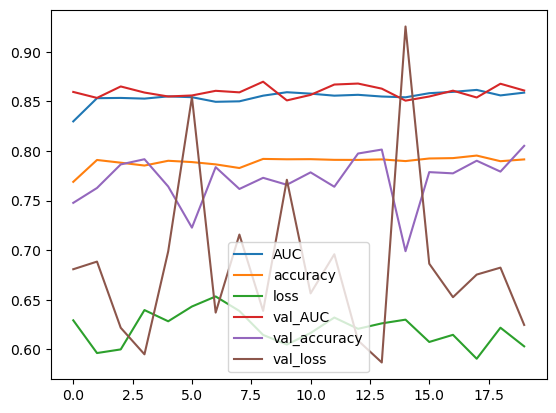

In [22]:
from tensorflow.keras.applications import ResNet152V2
from keras.applications.resnet_v2 import preprocess_input, decode_predictions

def build_resnet152v2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)) -> keras.Model:
    """
    Builds a ResNet152V2 model with transfer learning.
    """
    base_model = ResNet152V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False  # Freeze the base model

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Preprocess the datasets
print("Preprocessing datasets with ResNet152V2 preprocess_input...")
preprocess_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
preprocess_val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# Build and compile the ResNet152V2 model
print("Building ResNet152V2 model...")
resnet152v2_model = build_resnet152v2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL))

resnet152v2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=get_lr_schedule()),
    loss=LOSS,
    metrics=METRICS
)
print(resnet152v2_model.summary())

# Fit the model
print("Fitting ResNet152V2 model...")
resnet152v2_history = resnet152v2_model.fit(
    preprocess_train_ds,
    validation_data=preprocess_val_ds,
    epochs=EPOCHS,
    class_weight=get_class_weights(df),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("checkpoints/resnet152v2/save_at_{epoch}.keras"),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# predict on the test dataset
print("Predicting on the test dataset with ResNet152V2 model...")
predictions, submission_path = predict_and_save_submission(resnet152v2_model, "resnet152v2", test_ds, output_dir='./submissions')
predictions = (predictions > 0.5).astype(int)  # Convert probabilities
predictions = predictions.flatten()
print(f"Predictions saved to {submission_path}")

# percent of predictions by label
print("Calculating prediction percentages...")
percent_0 = np.mean(predictions == 0) * 100
percent_1 = np.mean(predictions == 1) * 100
print(f"Predictions: {percent_0:.2f}% label 0, {percent_1:.2f}% label 1")
print(f"Total predictions: {len(predictions)}, label 0: {np.sum(predictions == 0)}, label 1: {np.sum(predictions == 1)}")

print("Plotting training history for ResNet152V2 model...")
pd.DataFrame(resnet152v2_history.history).plot()

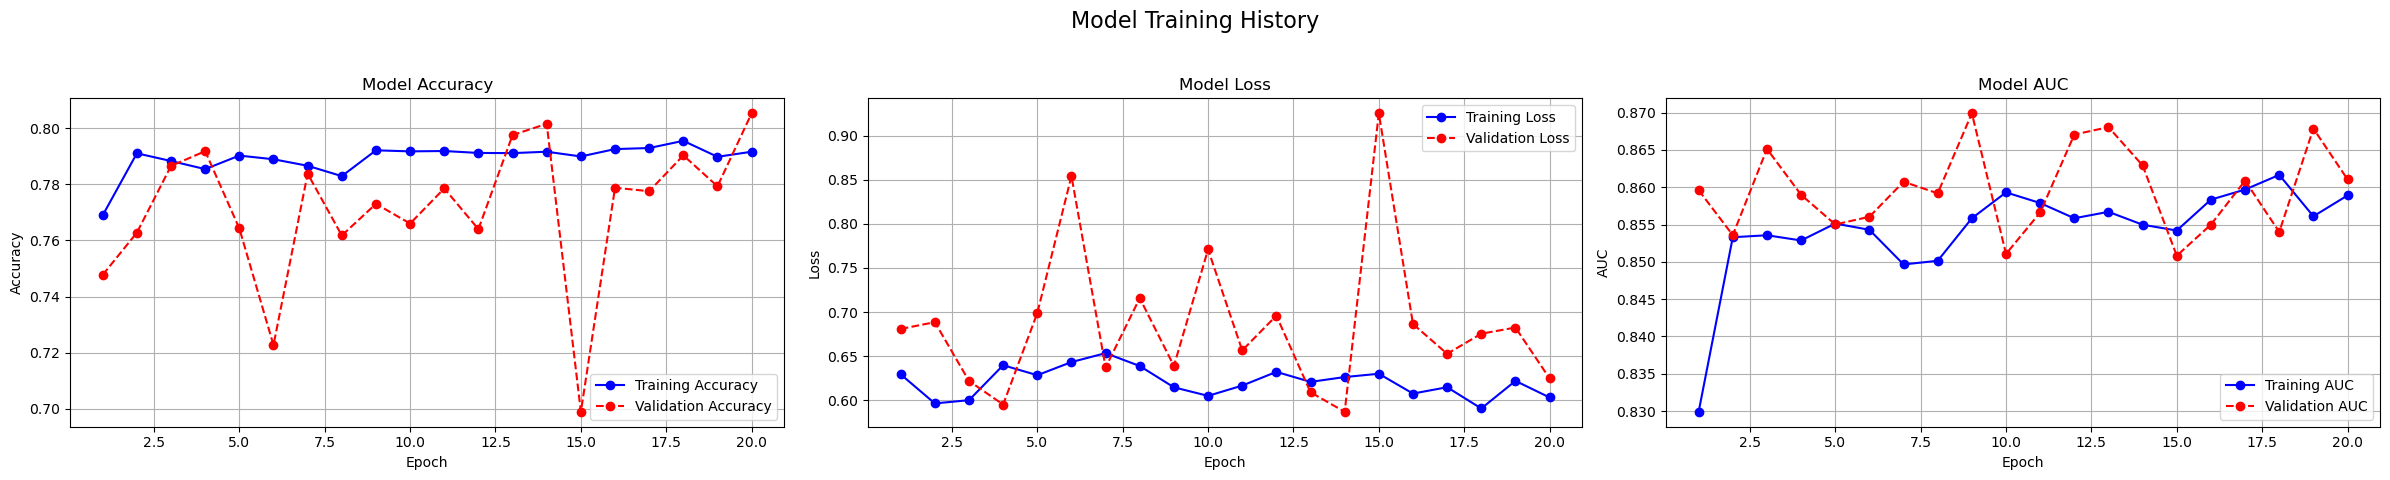

In [23]:
plot_training_history(resnet152v2_history)

## Fine-Tuning Strategy and Hyperparameters Tuning

After training the ResNet model, I unfreeze the last few layers of the model to fine-tune it. This allows the model to learn more specific features from the dataset. The unfreezing is done by setting `trainable=True` for the last few layers of the model.

I also use Keras Tuner to optimize the hyperparameters for the fine-tuning process. This includes tuning the learning rate, dropout rate, and the number of layers to unfreeze. The goal is to find the best combination of hyperparameters that improves the model's performance on the validation set.

In [25]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras-tuner]


In [26]:
import keras_tuner as kt

def build_finetune_model(hp) -> keras.Model:
    # Start from the pre-trained model (assuming it's already trained with frozen layers)
    model = resnet152v2_model
    
    # Hyperparameter: Number of layers to unfreeze
    num_unfreeze = hp.Int('num_unfreeze', min_value=10, max_value=50, step=10)
    
    # Set the entire base model to trainable, then freeze all but the last num_unfreeze layers
    base_model = model.layers[0]
    base_model.trainable = True
    for layer in base_model.layers[:-num_unfreeze]:
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze:]:
        layer.trainable = True
    
    # Hyperparameter: Learning rate
    lr = hp.Float('lr', min_value=1e-6, max_value=1e-4, sampling='log')
    
    # Hyperparameter: Dropout rate (optional addition for regularization)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    
    # Add dropout if >0 (insert before the final Dense layer)
    if dropout_rate > 0:
        # Rebuild the top layers with dropout
        new_model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation='sigmoid')
        ])
    else:
        new_model = model  # Keep original if no dropout
    
    # Compile with tuned hyperparameters
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=get_lr_schedule(lr=lr)),
        loss=LOSS,
        metrics=METRICS
    )
    
    return new_model

tuner = kt.RandomSearch(
    build_finetune_model,
    objective='val_auc',  # Optimize for validation AUC
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='resnet_finetune'
)

print("Starting hyperparameter tuning for fine-tuning...")
tuner.search(
    preprocess_train_ds,
    validation_data=preprocess_val_ds,
    epochs=EPOCHS,
    class_weight=get_class_weights(df),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
    ]
)

best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())

Trial 2 Complete [00h 15m 55s]

Best val_auc So Far: None
Total elapsed time: 00h 34m 09s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
40                |50                |num_unfreeze
1.1862e-06        |5.5747e-06        |lr
0.1               |0.3               |dropout_rate

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 113ms/step - AUC: 0.7360 - accuracy: 0.6661 - loss: 0.5953 - val_AUC: 0.9159 - val_accuracy: 0.8127 - val_loss: 0.4130
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - AUC: 0.9021 - accuracy: 0.8237 - loss: 0.4104 - val_AUC: 0.9272 - val_accuracy: 0.8280 - val_loss: 0.3740
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 99ms/step - AUC: 0.9144 - accuracy: 0.8394 - loss: 0.3726 - val_AUC: 0.9308 - val_accuracy: 0.8345 - val_loss: 0.3681
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - AUC: 0.9202 - accuracy: 0.8434 - loss: 0.3570 - val_AUC: 0.9326 - val_accuracy: 0.8355 - val_loss: 0.3638
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━

Traceback (most recent call last):
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/t

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 116, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "/Users/mark/miniconda3/envs/csca-5642-tf-mac/lib/python3.10/site-packages/keras_tuner/src/engine/objective.py", line 59, in get_value
    return logs[self.name]
KeyError: 'val_auc'


In [ ]:
resnet152v2_history_finetune = best_model.fit(
    preprocess_train_ds,
    validation_data=preprocess_val_ds,
    epochs=EPOCHS,
    class_weight=get_class_weights(df),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("checkpoints/resnet152v2-finetuned/save_at_{epoch}.keras"),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
    ]
)
# Predict on the test dataset with the fine-tuned model
print("Predicting on the test dataset with fine-tuned ResNet152V2 model...")
predictions, submission_path = predict_and_save_submission(best_model, "resnet152v2-finetuned", test_ds, output_dir='./submissions')
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary
predictions = predictions.flatten()
print(f"Predictions saved to {submission_path}")

# Calculate prediction percentages
print("Calculating prediction percentages for fine-tuned model...")
percent_0 = np.mean(predictions == 0) * 100
percent_1 = np.mean(predictions == 1) * 100
print(f"Predictions: {percent_0:.2f}% label 0, {percent_1:.2f}% label 1")
print(f"Total predictions: {len(predictions)}, label 0: {np.sum(predictions == 0)}, label 1: {np.sum(predictions == 1)}")

# Plot training history for fine-tuned model
print("Plotting training history for fine-tuned ResNet152V2 model...")
plot_training_history(resnet152v2_history_finetune)

## Model Comparison

Finally, I compare the performance of the simple CNN model and the ResNet model. The ResNet model is expected to perform better due to its depth and pre-trained weights, but it is also more complex and requires more computational resources.

In [ ]:
# compare the two models
# create a data frame with the model names and their validation AUC scores
model_comparison = pd.DataFrame({
    'Model': ['Simple CNN', 'ResNet152V2', 'ResNet152V2 Fine-Tuned'],
    'Validation AUC': [
        np.max(simple_cnn_history.history['val_AUC']),
        np.max(resnet152v2_history.history['val_AUC']),
        np.max(resnet152v2_history_finetune.history['val_AUC'])
    ],
    'Validation Accuracy': [
        np.max(simple_cnn_history.history['val_accuracy']),
        np.max(resnet152v2_history.history['val_accuracy']),
        np.max(resnet152v2_history_finetune.history['val_accuracy'])
    ],
    'Validation Loss': [
        np.min(simple_cnn_history.history['val_loss']),
        np.min(resnet152v2_history.history['val_loss']),
        np.min(resnet152v2_history_finetune.history['val_loss'])
    ]
})
print(f"Number of samples: {SAMPLE_SIZE}")
print("Model Comparison:")
model_comparison
